# ResNet Activations - 0.3m

In [1]:
BASE_RES = 0.3

In [2]:
from keras.applications.resnet50 import ResNet50, preprocess_input
#from keras.applications.resnet import ResNet101, preprocess_input
from keras.models import Model
from keras.preprocessing import image
from keras import models
from keras import layers
from keras import optimizers
from keras.models import model_from_json

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import sys
import os
import datetime

import altair as alt
alt.renderers.enable('notebook')

from PIL import Image

from dotenv import load_dotenv

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
sys.path.append("../Library/")
import deep_learning as dl
import image_manipulation as ima
import machine_learning as ml

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
def print_time(string=''):
    print('', str(datetime.datetime.today())[:22], string)
    return

# Load Image Batch

### Define degraded resolutions and image sizes for later use

In [7]:
sizes = {}
base_res = BASE_RES
base_size = 512

for factor in range(2, 17):
    res = round(base_res * factor,1)
    size = round(base_size/factor)
    sizes[res] = (size, size)
print("\nSizes dictionary:\n", sizes)


Sizes dictionary:
 {0.6: (256, 256), 0.9: (171, 171), 1.2: (128, 128), 1.5: (102, 102), 1.8: (85, 85), 2.1: (73, 73), 2.4: (64, 64), 2.7: (57, 57), 3.0: (51, 51), 3.3: (47, 47), 3.6: (43, 43), 3.9: (39, 39), 4.2: (37, 37), 4.5: (34, 34), 4.8: (32, 32)}


### Load Image Batch into DataFrame

In [8]:
base_folder = os.getenv('GDRIVE_FOLDER') + "MFP - Satellogic/images/usgs_512_res" + str(BASE_RES) + "m"
categories = ["forest-woodland", "agriculture", "shrubland-grassland", "semi-desert"]
data_folder_colab = os.getenv('GDRIVE_FOLDER').replace("MDS/","") + "Colab/MasterThesis/Data/" + str(BASE_RES) + "m"
results_folder_colab = os.getenv('GDRIVE_FOLDER').replace("MDS/","") + "Colab/MasterThesis/Results_" + str(BASE_RES) + "m_excl_label1"

In [9]:
%%time
labels = [0, 1, 2]
df_images = pd.DataFrame(columns = ['filename', 'image', 'resolution', 'label', 'category'])
for category in categories:
    for label in labels:
        print_time("loading " + category + " - label " + str(label) + "...")
        df = ima.load_images_into_df_by_category_and_label(base_folder, category, label)
        df_images = df_images.append(df)    

 2019-06-25 16:16:07.48 loading forest-woodland - label 0...
 2019-06-25 16:16:12.96 loading forest-woodland - label 1...
 2019-06-25 16:16:13.69 loading forest-woodland - label 2...
 2019-06-25 16:16:15.71 loading agriculture - label 0...
 2019-06-25 16:16:15.71 loading agriculture - label 1...
 2019-06-25 16:16:15.72 loading agriculture - label 2...
 2019-06-25 16:16:22.05 loading shrubland-grassland - label 0...
 2019-06-25 16:16:28.94 loading shrubland-grassland - label 1...
 2019-06-25 16:16:30.17 loading shrubland-grassland - label 2...
 2019-06-25 16:16:33.48 loading semi-desert - label 0...
 2019-06-25 16:16:38.70 loading semi-desert - label 1...
 2019-06-25 16:16:39.95 loading semi-desert - label 2...
CPU times: user 27.8 s, sys: 2.74 s, total: 30.6 s
Wall time: 36.3 s


In [10]:
print("Shape of df_images:", df_images.shape)
print("Distribution of categories and labels:\n", df_images.groupby(['category', 'label']).size().reset_index(name='counts'))
print("\nDistribution of labels:\n", df_images.groupby(['label']).size().reset_index(name='counts'))

Shape of df_images: (2218, 5)
Distribution of categories and labels:
               category  label  counts
0          agriculture      2     417
1      forest-woodland      0     335
2      forest-woodland      1      44
3      forest-woodland      2     107
4          semi-desert      0     304
5          semi-desert      1      67
6          semi-desert      2     231
7  shrubland-grassland      0     415
8  shrubland-grassland      1      84
9  shrubland-grassland      2     214

Distribution of labels:
    label  counts
0      0    1054
1      1     195
2      2     969


### Enhance Images DataFrame by Degraded Images

In [11]:
if False:

    df_degraded = ima.load_degraded_images_into_df(df_images, sizes, label = True)

    df_images = df_images.append(df_degraded)
    print("Shape of df_images:", df_images.shape)
    del df_degraded

### Generate data set X and y and save for Colab

In [12]:
X, y, filenames, categories = dl.generate_X_y_from_df(df_images)

Shape of image array is: (2218, 512, 512, 3)


In [13]:
X_l1, y_l1, filenames_l1, categories_l1 = X[y == 1], y[y == 1], filenames[y == 1], categories[y == 1] 
X_l1

array([[[[ 56,  75,  50],
         [ 39,  62,  43],
         [ 47,  68,  44],
         ...,
         [ 53,  77,  54],
         [ 39,  79,  51],
         [ 57,  86,  55]],

        [[ 55,  86,  47],
         [ 60,  82,  49],
         [ 65,  87,  54],
         ...,
         [ 54,  83,  55],
         [ 59,  83,  49],
         [ 67,  89,  52]],

        [[ 63,  84,  49],
         [ 72,  95,  51],
         [ 85,  96,  59],
         ...,
         [ 62,  87,  52],
         [ 58,  89,  55],
         [ 68,  92,  53]],

        ...,

        [[111, 108,  71],
         [142, 134,  85],
         [108, 109,  84],
         ...,
         [ 13,  36,  32],
         [ 32,  56,  32],
         [ 24,  47,  34]],

        [[ 85,  96,  66],
         [138, 129,  89],
         [141, 143,  89],
         ...,
         [ 42,  81,  39],
         [ 71,  91,  44],
         [ 29,  51,  33]],

        [[ 80,  93,  68],
         [131, 128,  89],
         [159, 162,  98],
         ...,
         [ 63,  90,  51],
        

In [14]:
from random import shuffle
random_order = [i for i in range(len(X))]
shuffle(random_order)

X, y, filenames, categories = X[random_order], y[random_order], filenames[random_order], categories[random_order]

not_label = y != 1
X, y, filenames, categories = X[not_label], y[not_label], filenames[not_label], categories[not_label]
y = np.array(ml.convert_encoding(y, ml.zero_encoding))

filename: 14skc100230_x132_y1156_size512_baseres0.3m.png
category: agriculture
label: 1


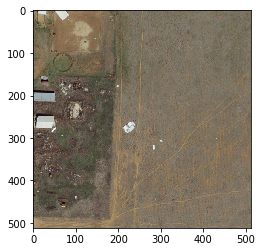

In [15]:
img = 0
print("filename:", filenames[img])
print("category:", categories[img])
print("label:", y[img])
plt.imshow(X[img])

In [16]:
X_name = 'X_images_res' + str(BASE_RES) + '.npy'
y_name = 'y_images_res' + str(BASE_RES) + '.npy'
filenames_name = 'filenames_images_res' + str(BASE_RES) + '.npy'
categories_name = 'categories_images_res' + str(BASE_RES) + '.npy'

In [17]:
np.save(os.path.join(data_folder_colab, X_name), X)
np.save(os.path.join(data_folder_colab, y_name), y)
np.save(os.path.join(data_folder_colab, filenames_name), filenames)
np.save(os.path.join(data_folder_colab, categories_name), categories)

In [18]:
X_l1_name = 'X_l1_images_res' + str(BASE_RES) + '.npy'
y_l1_name = 'y_l1_images_res' + str(BASE_RES) + '.npy'
filenames_l1_name = 'filenames_l1_images_res' + str(BASE_RES) + '.npy'
categories_l1_name = 'categories_l1_images_res' + str(BASE_RES) + '.npy'

np.save(os.path.join(results_folder_colab, X_l1_name), X_l1)
np.save(os.path.join(results_folder_colab, y_l1_name), y_l1)
np.save(os.path.join(results_folder_colab, filenames_l1_name), filenames_l1)
np.save(os.path.join(results_folder_colab, categories_l1_name), categories_l1)